In [97]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime
import csv

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets"
DATASET = ["scirep-cuisines-detail","Yummly28"]
FILES = ["random","cluster_centroid","full"]
dataset = DATASET[1]
file = FILES[2]

In [3]:
# FROM NN_classification
def createDFrame(file):
    
    dataset = DATASET[1]
    df = pd.read_pickle(os.path.join(
        FOLDER_PATH, dataset, file+"_data.pkl"))
    df = df.set_index("id")
    len1 = len(df)

    dataset = DATASET[0]
    df2 = pd.read_pickle(os.path.join(
        FOLDER_PATH, dataset, file+"_data.pkl"))
    df2["id"] = [len(df)+i for i in range(len(df2))]
    df2 = df2.set_index("id")
    df = pd.concat([df, df2],sort=False)
    if len(df)!=len1+len(df2):
        print("Error! Missing data")

    return df

df_train = createDFrame(FILES[2])

In [4]:
cv = CountVectorizer()
X = cv.fit_transform(df_train['all_ingredients'].values)

## Processing

In [5]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape

['African' 'Asian' 'EastAsian' 'EasternEuropean' 'LatinAmerican'
 'MiddleEastern' 'NorthAmerican' 'NorthernEuropean' 'SouthAsian'
 'SoutheastAsian' 'SouthernEuropean' 'WesternEuropean']


(12,)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 72,
 1: 629,
 2: 558,
 3: 76,
 4: 1269,
 5: 129,
 6: 10804,
 7: 50,
 8: 416,
 9: 161,
 10: 1793,
 11: 849}

# Logistic Regression

In [60]:
parameters = {'C':[0.4,0.5,0.6,0.7],
              'solver' : ('newton-cg', 'liblinear')}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
logistic = LogisticRegression(class_weight="balanced",multi_class="auto",max_iter=150,warm_start=True)

clf = GridSearchCV(logistic, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=150, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=True),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.4, 0.5, 0.6, 0.7],
                         'solver': ('newton-cg', 'liblinear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

## Results

In [61]:
# pd.DataFrame(clf.cv_results_)
print(clf.best_estimator_)
clf.best_score_
# LogisticRegression(C=0.6, class_weight='balanced', dual=False,
#                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                    max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
#                    warm_start=True)

# LogisticRegression(C=0.4, class_weight='balanced', dual=False,
#                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                    max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
#                    warm_start=True)

LogisticRegression(C=0.7, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)


0.7401066462145605

In [62]:
test_score = clf.best_estimator_.score(X_test, y_test)
test_score

0.7209330001190051

In [98]:
# For future predictions, get proba and only classifies if proba is higher than threshold
def threshold_classification(clf,X_test,y_test,threshold=0.85):
    y_pred_prob = clf.predict_proba(X_test)
    max_prob = y_pred_prob.max(axis=1)
    y_pred = y_pred_prob.argmax(axis=1)

    to_del = np.argwhere(max_prob < threshold).T[0]

    partial_y_pred = np.delete(y_pred,to_del)
    partial_y_test = np.delete(y_test,to_del)

    proba_score = accuracy_score(partial_y_test,partial_y_pred) #0.9373983739837398
    
    return proba_score

threshold = 0.95
proba_score = threshold_classification(clf,X_test,y_test,threshold=threshold)
proba_score

0.9726027397260274

In [65]:
def confusion_matrix_plot(y_pred,y_labels,save_path,name):
    fig = plt.figure(figsize=(10, 10))

    cm = confusion_matrix(y_labels, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title(name+" Confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = df_train['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, enc.classes_, rotation=90)
    plt.yticks(tick_marks, enc.classes_)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.show()
    
    fig.savefig(save_path, dpi=fig.dpi)

In [66]:
date = datetime.now().strftime("%m-%d-%H-%M")
RESULTS_FOLDER = os.path.join(FOLDER_PATH,dataset,f"results_ML_{date}_{file}")
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


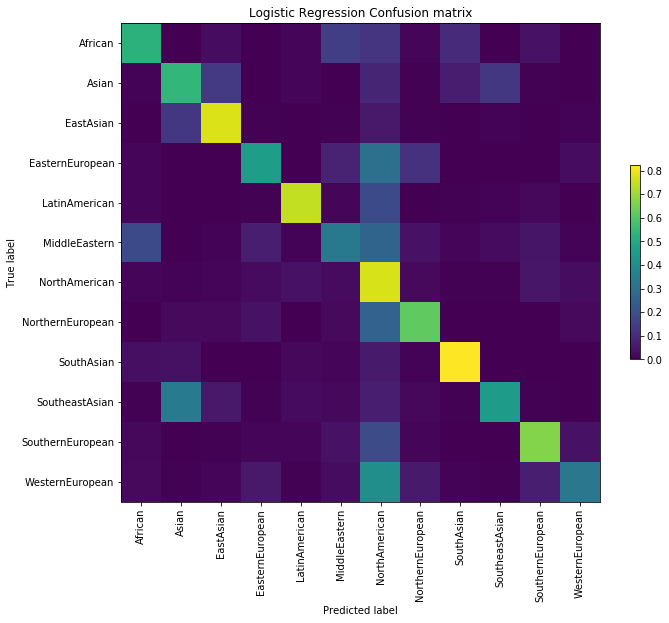

In [67]:
y_pred = clf.best_estimator_.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'logistic_regression.png'),"Logistic Regression")

In [29]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.7209330001190051
0.7749163175492334
0.7209330001190051
0.7424462159082974


In [20]:
def classification_report_to_csv(y_test,y_pred,enc,model_type,RESULTS_FOLDER):
    report = classification_report(y_test, y_pred, labels=[i for i in range(enc.classes_.shape[0])], target_names=enc.classes_, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(RESULTS_FOLDER,f'{model_type}.csv'))
    
classification_report_to_csv(y_test,y_pred,enc,"logistic_regression",RESULTS_FOLDER)    

## Saving results

In [21]:
results_file = os.path.join(RESULTS_FOLDER,"results.csv")
with open(results_file,"w", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["model","best parameters","best f1 train score","test score","threshold","proba score"])
    writer.writerow(["logistic regression",clf.best_estimator_,clf.best_score_,test_score,threshold,proba_score])

# SVM

In [31]:
parameters = {'loss':('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
              }
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
sgd = SGDClassifier(class_weight="balanced",early_stopping=True,warm_start=True)

clf3 = GridSearchCV(sgd, parameters, cv=4,scoring=scoring)
clf3.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=True, epsilon=0.1, eta0=0.0,
                                     fit_intercept=True, l1_ratio=0.15,
                                     learning_rate='optimal', loss='hinge',
                                     max_iter=1000, n_iter_no_change=5,
                                     n_jobs=None, penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=True),
             iid='deprecated', n_jobs=None,
             param_grid={'loss': ('hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=F

In [32]:
print(clf3.best_estimator_)
clf3.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=True)


0.7218088919007111

In [33]:
clf3.best_estimator_.score(X_test, y_test)

0.6922527668689754

In [34]:
proba_score = threshold_classification(clf3,X_test,y_test,threshold=threshold)
proba_score

0.9727626459143969

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


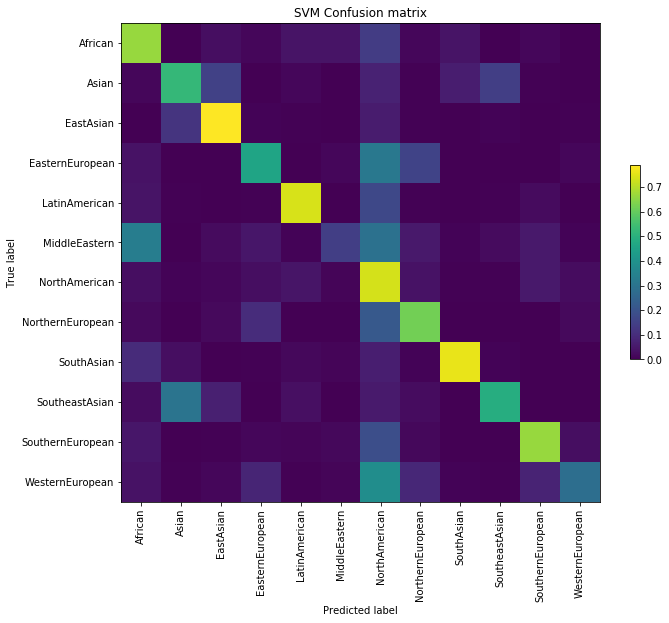

In [68]:
y_pred = clf3.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'svm.png'),"SVM")

In [36]:
classification_report_to_csv(y_test,y_pred,enc,"svm",RESULTS_FOLDER)    

In [37]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.6922527668689754
0.7685927847249543
0.6922527668689754
0.7221694537455265


In [38]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["svm",clf3.best_estimator_,clf3.best_score_,test_score,threshold,proba_score])

# Naive Bayes

In [39]:
parameters = {'alpha':[i*0.2 for i in range(1,5)]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
bayes = ComplementNB()

clf4 = GridSearchCV(bayes, parameters, cv=4,scoring=scoring)
clf4.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                                    norm=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.2, 0.4, 0.6000000000000001, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [40]:
clf4.best_score_

0.7103931897574518

In [41]:
clf4.score(X_test,y_test)

0.7161083604381949

In [42]:
proba_score = threshold_classification(clf4,X_test,y_test,threshold=threshold)
proba_score

0.9140749601275917

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


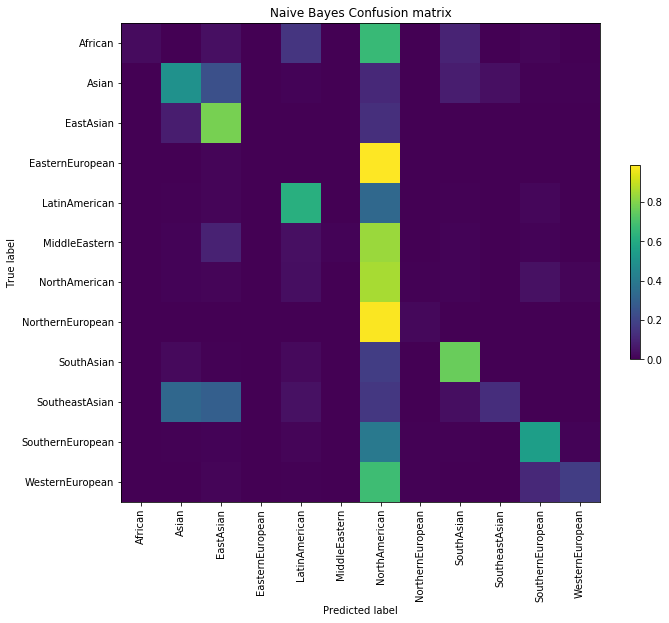

In [69]:
y_pred = clf4.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'naive_bayes.png'),"Naive Bayes")

In [44]:
classification_report_to_csv(y_test,y_pred,enc,"naive bayes",RESULTS_FOLDER)    

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.732238486254909
0.7133647949315773
0.732238486254909
0.7161083604381949


C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["naive bayes",clf4.best_estimator_,clf4.best_score_,test_score,threshold,proba_score])

# Decision Tree 

In [47]:
parameters = {"criterion":["gini","entropy"],
            "splitter":["best","random"]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
dec_tree = DecisionTreeClassifier()

clf5 = GridSearchCV(dec_tree, parameters, cv=4,scoring=scoring)
clf5.fit(X_train, y_train)
clf5.best_score_

0.682646997529578

In [48]:
clf5.score(X_test,y_test)

0.6886391233563989

In [49]:
proba_score = threshold_classification(clf5,X_test,y_test,threshold=threshold)
proba_score

0.6950718036313026

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


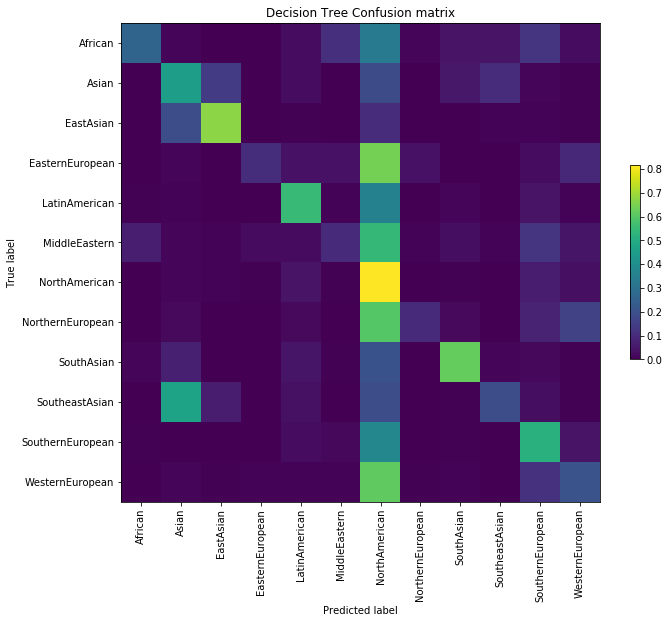

In [70]:
y_pred = clf5.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'dec_tree.png'),"Decision Tree")

In [51]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.691360228489825
0.6864531316184175
0.691360228489825
0.6886391233563989


In [52]:
classification_report_to_csv(y_test,y_pred,enc,"dec_tree",RESULTS_FOLDER)    

In [53]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["dec_tree",clf5.best_estimator_,clf5.best_score_,test_score,threshold,proba_score])

# Extra Tree 

In [54]:
parameters = {"criterion":["gini","entropy"]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
extra_tree = ExtraTreesClassifier()

clf6 = GridSearchCV(extra_tree, parameters, cv=4,scoring=scoring)
clf6.fit(X_train, y_train)
clf6.best_score_

0.7302951238122888

In [55]:
clf6.score(X_test,y_test)

0.7356803455517605

In [56]:
proba_score = threshold_classification(clf6,X_test,y_test,threshold=threshold)
proba_score

0.8590766255740875

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


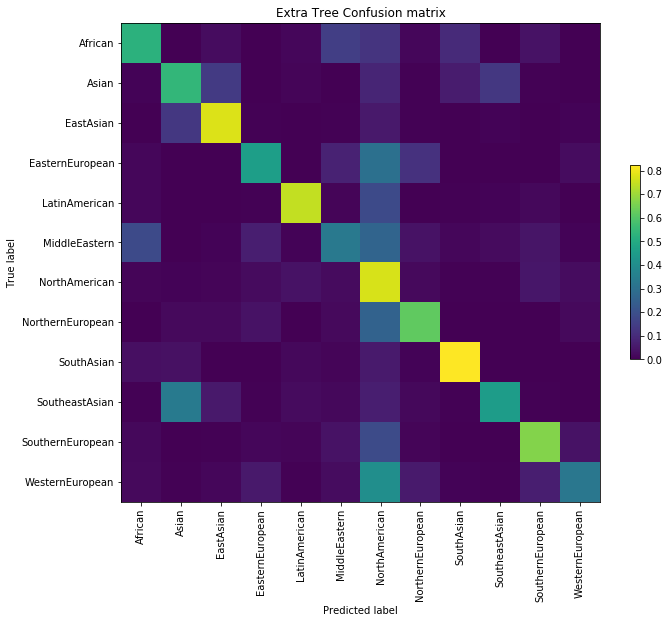

In [71]:
y_pred = clf.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'extra_tree.png'),"Extra Tree")

In [72]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.7209330001190051
0.7749163175492334
0.7209330001190051
0.7424462159082974


In [73]:
classification_report_to_csv(y_test,y_pred,enc,"extra_tree",RESULTS_FOLDER)    

In [74]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["extra_tree",clf6.best_estimator_,clf6.best_score_,test_score,threshold,proba_score])

## KNeighbors Classifier

In [75]:
parameters = {"n_neighbors":[i for i in range(3,7)],
            "weights":["uniform","distance"]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
kneigh = KNeighborsClassifier()

clf7 = GridSearchCV(kneigh, parameters, cv=4,scoring=scoring)
clf7.fit(X_train, y_train)
clf7.best_score_

0.6325864694989187

In [76]:
clf7.score(X_test,y_test)

0.6410371620395355

In [77]:
proba_score = threshold_classification(clf7,X_test,y_test,threshold=threshold)
proba_score

0.8176284941388638

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


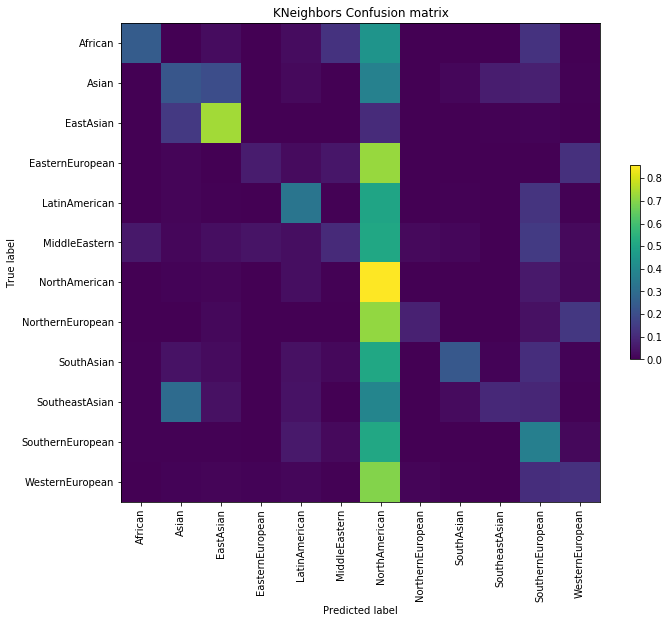

In [78]:
y_pred = clf7.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'KNeighbors.png'),"KNeighbors")

In [79]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.6641675592050458
0.6338929098861638
0.6641675592050458
0.6410371620395355


In [80]:
classification_report_to_csv(y_test,y_pred,enc,"KNeighbors",RESULTS_FOLDER)    

In [81]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["KNeighbors",clf7.best_estimator_,clf7.best_score_,test_score,threshold,proba_score])

## Linear SVC

In [100]:
parameters = {"penalty":["l1","l2"],
             "dual":[False,True],
             "C":[i for i in range(1,5)]}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
svc = LinearSVC()

#clf8 = GridSearchCV(svc, parameters, cv=4,scoring=scoring)
clf8 = CalibratedClassifierCV(svc,method="sigmoid",cv=4)
clf8.fit(X_train, y_train)

AttributeError: 'CalibratedClassifierCV' object has no attribute 'best_score_'

In [104]:
dir(clf8.calibrated_classifiers_[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_preproc',
 'base_estimator',
 'calibrators_',
 'classes',
 'classes_',
 'fit',
 'label_encoder_',
 'method',
 'predict_proba']

In [106]:
clf8.score(X_test,y_test)

0.7808520766392955

In [105]:
proba_score = threshold_classification(clf8,X_test,y_test,threshold=threshold)
proba_score

0.9797724399494311

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


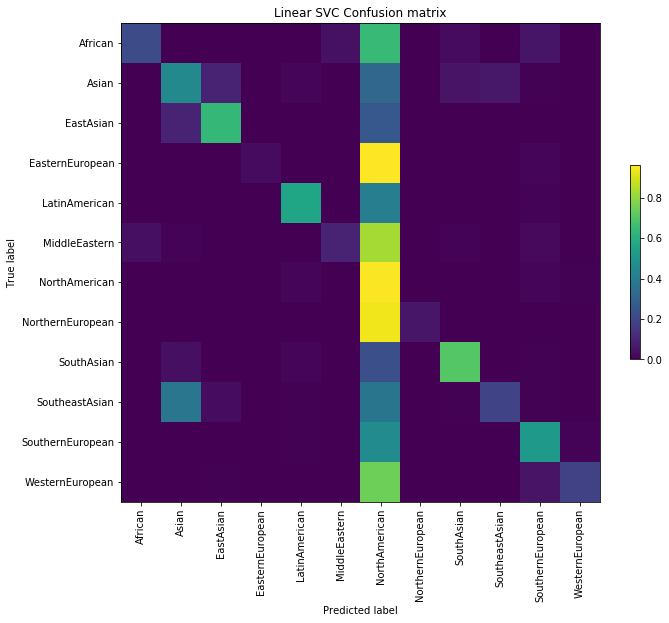

In [107]:
y_pred = clf8.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'Linear SVC.png'),"Linear SVC")

In [86]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.7806735689634654
0.7657084258311304
0.7806735689634654
0.7556603532945328


In [87]:
classification_report_to_csv(y_test,y_pred,enc,"Linear SVC",RESULTS_FOLDER)    

In [88]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["Linear SVC",clf8.best_estimator_,clf8.best_score_,test_score,threshold,proba_score])

# Random Forest

much slower and a bit worse

In [89]:
parameters = {'max_depth':(None,3,5,8)}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
rf = RandomForestClassifier(n_estimators=200, random_state=123,class_weight="balanced")

clf2 = GridSearchCV(rf, parameters, cv=4,scoring=scoring)
clf2.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=123,
                           

In [90]:
print(clf2.best_estimator_)
clf2.best_score_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


0.7022417689978948

In [91]:
clf2.best_estimator_.score(X_test, y_test)

0.7413423777222421

In [92]:
proba_score = threshold_classification(clf2,X_test,y_test,threshold=threshold)
proba_score

0.972131908964236

C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


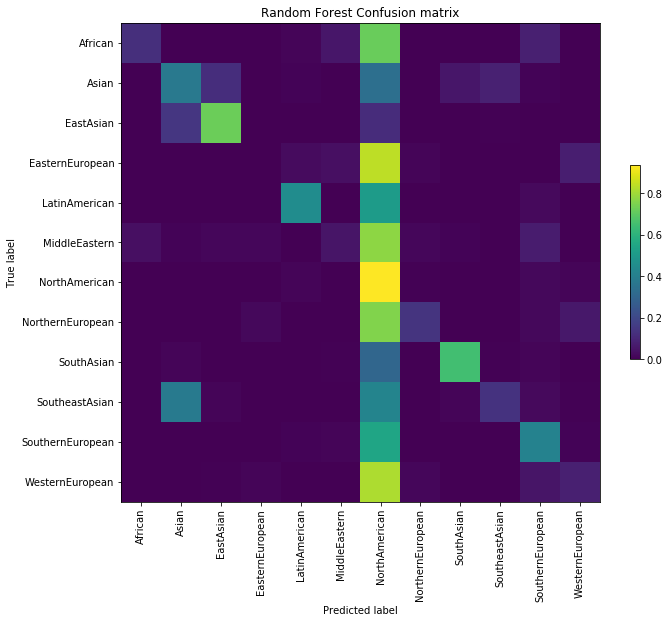

In [93]:
%matplotlib inline
y_pred = clf2.predict(X_test)
confusion_matrix_plot(y_pred, y_test,os.path.join(RESULTS_FOLDER,'random_forest.png'),"Random Forest")

In [94]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred,average='weighted'))
print(recall_score(y_test,y_pred,average='weighted'))
print(f1_score(y_test,y_pred,average='weighted'))

0.7413423777222421
0.7132260331379092
0.7413423777222421
0.7106104575473718


In [95]:
classification_report_to_csv(y_test,y_pred,enc,"Random Forest",RESULTS_FOLDER)

In [96]:
with open(results_file,"a", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["random forest",clf2.best_estimator_,clf2.best_score_,test_score,threshold,proba_score])